In [10]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [11]:
with open('dataset/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [12]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C) 16,32,16
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # Projection layer going back into the residual pathway
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


In [13]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))    # Communication
        x = x + self.ffwd(self.ln2(x))  # Computation
        return x

In [14]:
# super simple language model
class LanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [15]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [16]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4
dropout = 0.0
# ------------

I have to admit that I was a little confused what you meant with max_iters=5000, eval_interval=10 and eval_iters=200 and no hyperparameter on the amount of epochs.

If you meant train one epoch for 5000 iterations and every 10 iterations evaluate for 200 iterations, which is what I thought initially, then the evaluation takes 4 times the processing power of the training and that seemed a little excessive and in 10 iterations not so much changed. Also the model was not fully trained after 5000 iterations.

If yu meant train for some amount of epochs each with 5000 iterations and evaluate every 10th epoch then most of the interesting behaviour would be missed.

Therefore I adapted to 20 epochs with 500 iterations each and after every epoch an evaluation with 200 iterations. Hope this was ok.

In [30]:
# hyperparameters
n_embd = 768
n_head = 12
n_layer = 12

max_epochs=20
max_iters = 500
eval_interval = 1

In [31]:
model = LanguageModel()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

print('Starting Training')
for epoch in tqdm(range(max_epochs)):
    model.train()
    for i in range(max_iters):
        # Get batch of training data
        X, Y = get_batch('train')

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        logits, loss = model(X, Y)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    # Print and save statistics
    if epoch % eval_interval == (eval_interval - 1):  # Evaluate every eval_interval epoch
        loss_dict = estimate_loss()
        print('Epoch %d: Training Loss: %.3f, Validation Loss: %.3f' % (epoch+1, loss_dict['train'], loss_dict['val']))
        train_losses.append(loss_dict['train'])
        val_losses.append(loss_dict['val'])

print('Finished Training')

Starting Training


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Training Loss: 2.390, Validation Loss: 2.407
Epoch 2: Training Loss: 2.222, Validation Loss: 2.238
Epoch 3: Training Loss: 2.158, Validation Loss: 2.201
Epoch 4: Training Loss: 2.075, Validation Loss: 2.137
Epoch 5: Training Loss: 2.185, Validation Loss: 2.247
Epoch 6: Training Loss: 2.185, Validation Loss: 2.226
Epoch 7: Training Loss: 2.185, Validation Loss: 2.239
Epoch 8: Training Loss: 2.224, Validation Loss: 2.276
Epoch 9: Training Loss: 2.224, Validation Loss: 2.269
Epoch 10: Training Loss: 2.211, Validation Loss: 2.250
Epoch 11: Training Loss: 2.209, Validation Loss: 2.257
Epoch 12: Training Loss: 2.237, Validation Loss: 2.283
Epoch 13: Training Loss: 2.377, Validation Loss: 2.398
Epoch 14: Training Loss: 2.377, Validation Loss: 2.412
Epoch 15: Training Loss: 2.340, Validation Loss: 2.382
Epoch 16: Training Loss: 2.322, Validation Loss: 2.359
Epoch 17: Training Loss: 2.316, Validation Loss: 2.336
Epoch 18: Training Loss: 2.381, Validation Loss: 2.410
Epoch 19: Training 

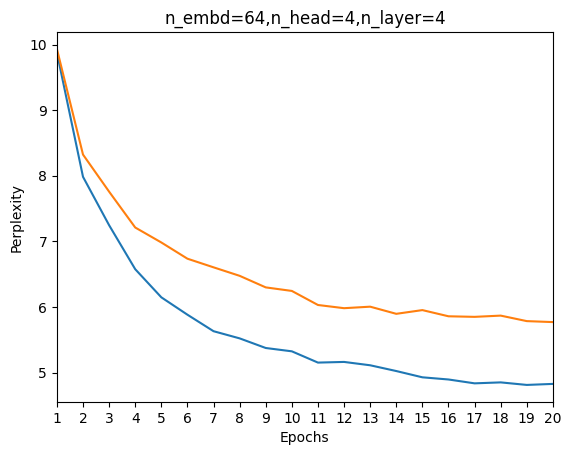

Minimum Training Perplexity:  4.81, Minimum Validation Perplexity:  5.77
Testing generator with following prompt ("My dog really wanted to"):

My dog really wanted to kill'd?

HENRY VI:
Way, who, rever here in not
whithous ove


In [48]:
plt.plot(range(1,21),np.exp(train_losses))
plt.plot(range(1,21),np.exp(val_losses))
plt.xlim([1,20])
plt.xticks(range(1,21))
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('n_embd=64,n_head=4,n_layer=4')
plt.show()
print('Minimum Training Perplexity:  %.2f, Minimum Validation Perplexity:  %.2f' %(np.min(np.exp(train_losses)),np.min(np.exp(val_losses))))

text = "My dog really wanted to"
print('Testing generator with following prompt ("'+text+'"):\n')
input = torch.tensor(encode(text), dtype=torch.long)
input = input[None,:].to(device)
out=model.generate(input, max_new_tokens=60)
print(decode(out.flatten().tolist()))

This is the base model. It seems to be rather badly trained by now but from the training and validation perplexity it seems like not so much is changing anymore. I would suspect that the model has too low complexity for understanding the text thus increasing theembedding from 64 to 128 allows the model to learn more complex representations, potentially capturing more intricate patterns in the data.

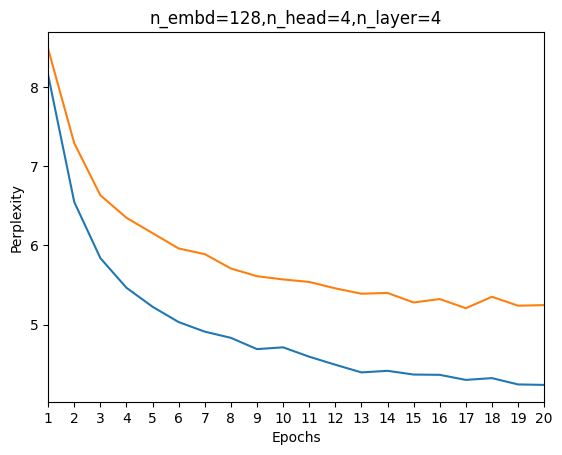

Minimum Training Perplexity:  4.24, Minimum Validation Perplexity:  5.21
Testing generator with following prompt ("My dog really wanted to"):

My dog really wanted to her: him's should with thou.

JOHN OF YORN:
Pierce should w


In [51]:
plt.plot(range(1,21),np.exp(train_losses))
plt.plot(range(1,21),np.exp(val_losses))
plt.xlim([1,20])
plt.xticks(range(1,21))
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('n_embd=128,n_head=4,n_layer=4')
plt.show()
print('Minimum Training Perplexity:  %.2f, Minimum Validation Perplexity:  %.2f' %(np.min(np.exp(train_losses)),np.min(np.exp(val_losses))))

text = "My dog really wanted to"
print('Testing generator with following prompt ("'+text+'"):\n')
input = torch.tensor(encode(text), dtype=torch.long)
input = input[None,:].to(device)
out=model.generate(input, max_new_tokens=60)
print(decode(out.flatten().tolist()))

This model performed a little better but still not so good and therefore I would increase the amount of layers from 4 to 8, to allow the model to learn more complex hierarchical representations to potentially capture longer-range dependencies.

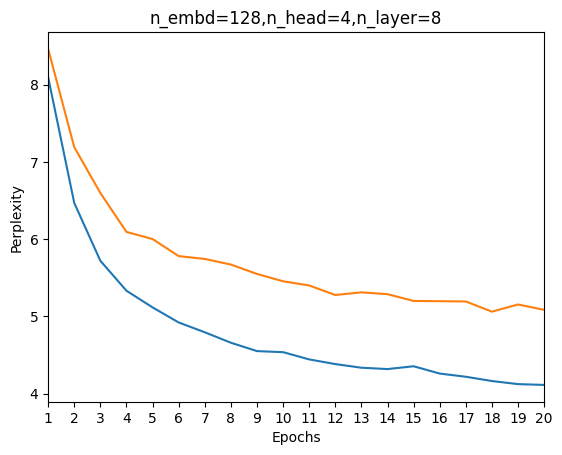

Minimum Training Perplexity:  4.11, Minimum Validation Perplexity:  5.06
Testing generator with following prompt ("My dog really wanted to"):

My dog really wanted to it arms too robberd;
No hather as him at a worthive ill.
We


In [22]:
plt.plot(range(1,21),np.exp(train_losses))
plt.plot(range(1,21),np.exp(val_losses))
plt.xlim([1,20])
plt.xticks(range(1,21))
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('n_embd=128,n_head=4,n_layer=8')
plt.show()
print('Minimum Training Perplexity:  %.2f, Minimum Validation Perplexity:  %.2f' %(np.min(np.exp(train_losses)),np.min(np.exp(val_losses))))

text = "My dog really wanted to"
print('Testing generator with following prompt ("'+text+'"):\n')
input = torch.tensor(encode(text), dtype=torch.long)
input = input[None,:].to(device)
out=model.generate(input, max_new_tokens=60)
print(decode(out.flatten().tolist()))

This model performed again a little better but still not so good as you can see from the generated text. Next I would increase the amount of attention heads from 4 to 8 allows the model to attend to more parts of the input sequence simultaneously. To not decrease with that the head_size I will increase at the same time the amount of embedding from 128 to 256.

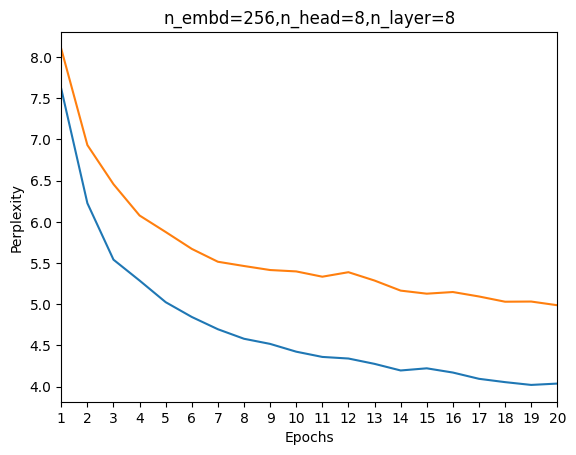

Minimum Training Perplexity:  4.02, Minimum Validation Perplexity:  4.99
Testing generator with following prompt ("My dog really wanted to"):

My dog really wanted to joys till Bohemia
Honouse fear to Mantague that Romeo's bid


In [27]:
plt.plot(range(1,21),np.exp(train_losses))
plt.plot(range(1,21),np.exp(val_losses))
plt.xlim([1,20])
plt.xticks(range(1,21))
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('n_embd=256,n_head=8,n_layer=8')
plt.show()
print('Minimum Training Perplexity:  %.2f, Minimum Validation Perplexity:  %.2f' %(np.min(np.exp(train_losses)),np.min(np.exp(val_losses))))

text = "My dog really wanted to"
print('Testing generator with following prompt ("'+text+'"):\n')
input = torch.tensor(encode(text), dtype=torch.long)
input = input[None,:].to(device)
out=model.generate(input, max_new_tokens=60)
print(decode(out.flatten().tolist()))

Once again this model had a slight improvement, supporting the thesis that the model has too little complexity to fully understand the text. As I know that big LLM models such as GPT consist usually of much more layers, attention heads and embedding dimensions, I will try in the last test to again increase all 3 parameters.

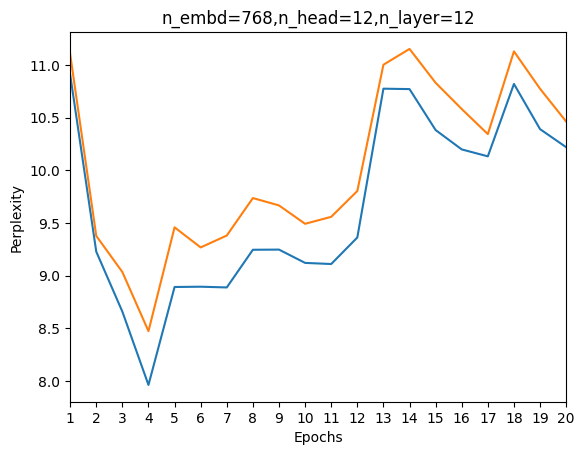

Minimum Training Perplexity:  7.96, Minimum Validation Perplexity:  8.47
Testing generator with following prompt ("My dog really wanted to"):

My dog really wanted to dechen thin'r the a hensu live
fr you go he. u Lowiry coure


In [32]:
plt.plot(range(1,21),np.exp(train_losses))
plt.plot(range(1,21),np.exp(val_losses))
plt.xlim([1,20])
plt.xticks(range(1,21))
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('n_embd=768,n_head=12,n_layer=12')
plt.show()
print('Minimum Training Perplexity:  %.2f, Minimum Validation Perplexity:  %.2f' %(np.min(np.exp(train_losses)),np.min(np.exp(val_losses))))

text = "My dog really wanted to"
print('Testing generator with following prompt ("'+text+'"):\n')
input = torch.tensor(encode(text), dtype=torch.long)
input = input[None,:].to(device)
out=model.generate(input, max_new_tokens=60)
print(decode(out.flatten().tolist()))

Even though this model should perform best, as it is the one with the highest complexity, it performed much worse and seemed not to be able to really train on the data. Training large models can be challenging and may lead to instability during training, e.g. if diminishing gradients are occurring. In any case it is clear that this model was unstable for the training loop.